# Solving sphere torsion problem

In this notebook, we develop the spherical harmonic solution of the tensile-hole problem. The problem can be described in the following figure:

Here the traction boundary is given as:

$$
\mathbf{T}_{\varphi} = S_0\sin(2\theta);\quad\mathbf{T}_{\theta}=\mathbf{T}_{R}=0
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from SHUtil import SHCilmToVector, lmk2K, K2lmk
import time

S0 = 1
a = 1
mu = 1
nu = 1./3

#### traction mode matrix info ####
lJmax = 4 # max l degree for saving a single mode
lKmax = 4 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
Ngrid = 100
theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)

THETA, PHI = np.meshgrid(theta, phi)
Z = np.cos(THETA)
X = np.sin(THETA)*np.cos(PHI)
Y = np.sin(THETA)*np.sin(PHI)
R = np.sqrt(X**2+Y**2+Z**2)
N = np.stack((X/R, Y/R, Z/R), axis=-1)

T_mag = S0*np.sin(2*THETA)
T_usr_mesh = np.zeros(THETA.shape+(3,))
T_usr_mesh[...,0] = T_mag*np.cos(np.pi/2+PHI)
T_usr_mesh[...,1] = T_mag*np.sin(np.pi/2+PHI)

T_usr_vec = np.array([])
for k in range(3):
    T_usr_cilm = pyshtools.expand.SHExpandDHC(T_usr_mesh[...,k].T, sampling=2, lmax_calc=lJmax)
    T_usr_vec = np.hstack((T_usr_vec, SHCilmToVector(T_usr_cilm, lmax = lJmax)))

print(T_usr_vec[np.nonzero(np.abs(T_usr_vec)>1e-8)])
### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from ShElastic import calSmode
from SHBV import generate_submat, visualize_Cmat
import time
ticT = time.time()
shtype = 'reg'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
tocT = time.time()
print(tocT-ticT)

[-6.47612561e-17+3.65148372e-01j  7.61794542e-17+3.65148372e-01j
 -3.65148372e-01-6.13957883e-17j  3.65148372e-01-7.12665574e-17j]
0.11807656288146973


Then we solve the linear system:

In [2]:
from SHBV import print_SH_mode
from scipy.sparse.linalg import lsqr
import time

tic = time.time()
A = lsqr(Cmat, T_usr_vec.transpose())
toc = time.time()
print('Residual:', A[3], 'Time:', toc-tic)
A_sol = A[0]
print('Solution:', A_sol.size)
print(T_usr_vec.T-np.dot(Cmat.todense(), A[0]))
index_sol = print_SH_mode(A_sol, m_dir=3)

Residual: 9.221800672163129e-15 Time: 0.001861572265625
Solution: 75
[[-6.90512406e-20+8.24835703e-50j  8.88443853e-19+4.84016828e-17j
  -9.05988249e-18+6.33808989e-34j  7.11356259e-19+7.76635148e-17j
  -8.74602343e-19-3.11013681e-18j  6.28478586e-16-1.66533454e-15j
  -1.14919280e-18+2.31115587e-34j -6.50150006e-16-1.60982339e-15j
  -8.74602343e-19+3.11013681e-18j  1.68293586e-19+2.61806819e-18j
   4.70938583e-18+6.57116574e-17j -2.52528884e-18+6.47230078e-18j
  -7.79477285e-18+8.03026794e-34j  1.69081677e-18+1.34891281e-17j
   4.70938583e-18-6.57116574e-17j -1.74044086e-18+6.25930258e-18j
  -2.56896134e-18+4.86446919e-18j  1.75752840e-15+2.60855370e-15j
  -4.65395799e-19-3.37885761e-18j  6.15932553e-16+9.84730938e-16j
  -2.18101974e-18+4.64204890e-35j -6.13582740e-16+9.88075005e-16j
  -4.65395799e-19+3.37885761e-18j -1.74832495e-15+2.56509476e-15j
  -2.56896134e-18-4.86446919e-18j  4.89692581e-20+8.56643248e-49j
  -5.69071986e-17-3.16201070e-18j -4.62215511e-17-4.37227997e-34j
   9.66

And integrate the stress solution:

In [3]:
from SHBV import fast_stress_solution

X = np.linspace(0.01, np.sqrt(2)/2, 30)
Z = np.linspace(0.01, np.sqrt(2)/2, 30)
Y = np.zeros_like(Z)

R,THETA,PHI = CartCoord_to_SphCoord(X, Y, Z)

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(30, 3, 3) 0.07988238334655762


We compare the solution with the analytical solution of the problem:

In [4]:
E3 = 2*S0/3/a
R = np.sqrt(X**2+Y**2+Z**2)
THETA = np.arccos(Z/R)
PHI = np.arctan2(Y, X)

srp = 3*E3*R*np.sin(THETA)*np.cos(THETA)
stp = -3*E3*R*np.sin(THETA)**2
print(X.shape, srp.shape, stp.shape)

(30,) (30,) (30,)


In [5]:
Q = np.zeros(THETA.shape+(3,3))
Q[...,0,0] = np.sin(THETA)*np.cos(PHI)
Q[...,0,1] = np.sin(THETA)*np.sin(PHI)
Q[...,0,2] = np.cos(THETA)
Q[...,1,0] = np.cos(THETA)*np.cos(PHI)
Q[...,1,1] = np.cos(THETA)*np.sin(PHI)
Q[...,1,2] = -np.sin(THETA)
Q[...,2,0] = -np.sin(PHI)
Q[...,2,1] = np.cos(PHI)
Q[...,2,2] = 0
sigma_sph = np.zeros_like(sigma_tot)
for i in np.ndindex(THETA.shape):
    #print(i, sigma_tot[i].shape)
    sigma_sph[i] = np.dot(Q[i], np.dot(sigma_tot[i], Q[i].T))

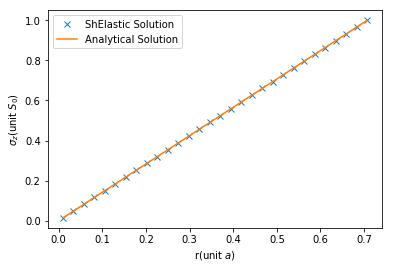

In [6]:
#plt.plot(X.flatten(), np.sqrt(sigma_tot.real[..., 1, 2].flatten()**2 + sigma_tot.real[..., 0, 2].flatten()**2) , 'x')
plt.plot(X.flatten(), sigma_sph.real[...,0, 2], 'x')
plt.plot(X.flatten(), srp)
plt.legend(['ShElastic Solution', 'Analytical Solution'])
plt.xlabel('r(unit $a$)')
plt.ylabel(r'$\sigma_z$(unit $S_0$)')
#plt.savefig('tensile_hole_sz.png')
plt.show()

## Test whether the stress field satisfy the eq cond. numerically

In [7]:
Ngrid = 100
theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)

THETA, PHI = np.meshgrid(theta, phi)
Z = np.cos(THETA)
X = np.sin(THETA)*np.cos(PHI)
Y = np.sin(THETA)*np.sin(PHI)
R = np.sqrt(X**2+Y**2+Z**2)
N = np.stack((X/R, Y/R, Z/R), axis=-1)

sigma_surf = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)

In [8]:
print(np.linalg.norm(T_usr_mesh-np.sum(sigma_surf.real*N[...,np.newaxis], axis=-2)))
#print(srp)
#print(T_mag)
#print(stp)
#print(np.linalg.norm(sigma_surf.real[...,1,0]))
#print(np.sqrt(sigma_surf.real[...,1,2]**2 + sigma_surf.real[...,0,2]**2))#-srp**2-stp**2)
#print(np.sqrt(T_usr_mesh[...,1]**2+T_usr_mesh[...,0]**2))
#print(T_usr_mesh[...,2].shape)

1.2125908040817662e-12


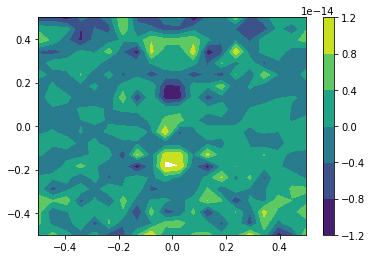

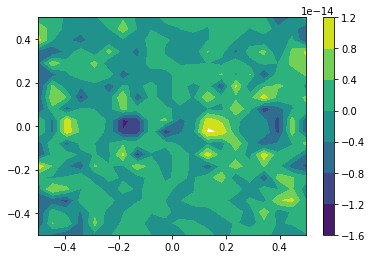

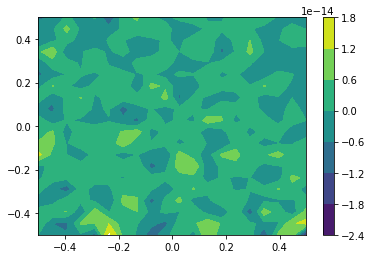

In [9]:
#from SHUtil import CartCoord_to_SphCoord, SphCoord_to_CartCoord, eval_GridC

# The order (Y,X,Z) makes sure that axis 0,1,2 corresponds to X,Y,Z
xgrid = np.linspace(-0.5, 0.5, 20)
Y, X, Z = np.meshgrid(xgrid, xgrid, xgrid)
R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
LAT = 90 - np.rad2deg(THETA)
LON = np.rad2deg(PHI)

MU = 1
NU = 1./3

S_grid = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)

for i in range(3):
    f0 = np.gradient(np.real(S_grid[:,:,:,i,0]), X[:,0,0],Y[0,:,0],Z[0,0,:])[0] +\
         np.gradient(np.real(S_grid[:,:,:,i,1]), X[:,0,0],Y[0,:,0],Z[0,0,:])[1] +\
         np.gradient(np.real(S_grid[:,:,:,i,2]), X[:,0,0],Y[0,:,0],Z[0,0,:])[2]

    plt.figure()
    plt.contourf(X[:,:,0],Y[:,:,0],f0[:,:,0])
    plt.colorbar()
plt.show()